In [264]:
%reload_ext autoreload
%autoreload 2

In [265]:
import sys
sys.path.append('../../modules')

import json

import numpy as np
from scipy.signal import savgol_filter
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

from env.gridworld import GridWorldWithWallsAndTraps
from policy import EpsilonGreedyPolicy
from algo.dp import PolicyIteration, PolicyEvaluation
from algo.td import NStepTDPrediction

In [266]:
nrows, ncols = 1, 15

In [267]:
grid_type_array = pd.read_csv("corridor.csv").fillna(0).to_numpy()[:nrows, 1:ncols+1]

In [268]:
grid_type_array

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.]])

In [269]:
env = GridWorldWithWallsAndTraps(grid_type_array)

In [270]:
mode='greedy'

In [271]:
if mode == 'greedy':
    repeat_policy = np.zeros((nrows, ncols)) + 1
    epsilon = 0
elif mode == 'epsilon-greedy':
    repeat_policy = np.zeros((nrows, ncols)) + 1
    epsilon = 0.8
elif mode == 'random':
    repeat_policy = np.zeros((nrows, ncols))
    epsilon = 1

In [272]:
q_init = np.zeros(env.action_space_shape)
for (i, j), val in np.ndenumerate(repeat_policy):
    q_init[i, j, int(val)] = 1

In [273]:
policy = EpsilonGreedyPolicy(q=q_init, epsilon=epsilon)

## Policy evaluation baseline

In [274]:
algo = PolicyEvaluation(
    env=env, 
    policy=policy, 
    discount_factor=0.95,
    truncate_pe=False, pe_tol=1e-3,
)
algo.run()

Running DP policy evaluation ...
Result: Convergence reached.


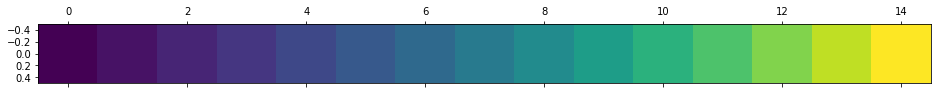

In [275]:
plt.matshow(algo.q.max(axis=-1))
plt.show()

## N-step TD prediction

In [276]:
td = NStepTDPrediction(
    env=env, policy=policy, 
    alpha=0.1, n=3, gamma=0.95, use_td_errors=True, true_v=algo.q.max(axis=-1)
)

td_rms_errors = td.run(max_iterations=500, which_tqdm='notebook', seed=30)

In [277]:
td2 = NStepTDPrediction(
    env=env, policy=policy, 
    alpha=0.1, n=3, gamma=0.95, use_td_errors=False, true_v=algo.q.max(axis=-1)
)

td_rms_errors2 = td2.run(max_iterations=500, which_tqdm='notebook', seed=30)

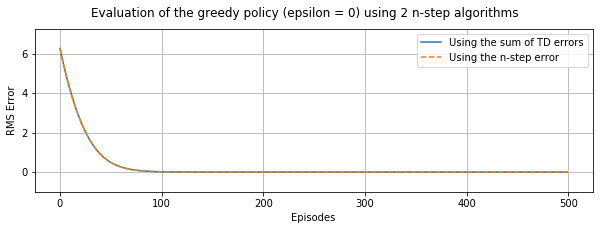

In [280]:
fig = plt.figure(figsize=(10,  3))

plt.plot(td_rms_errors, label='Using the sum of TD errors')
if mode == 'greedy':
    plt.plot(td_rms_errors2, '--', label='Using the n-step error')
else:
    plt.plot(td_rms_errors2, label='Using the n-step error')

plt.grid()
plt.ylim(0-1, np.max(td_rms_errors2)+1)

plt.xlabel('Episodes')
plt.ylabel('RMS Error')
plt.legend()

plt.suptitle(f'Evaluation of the {mode} policy (epsilon = {epsilon}) using 2 n-step algorithms')
plt.savefig(f'{mode}.png', dpi=300, bbox_inches = 'tight', pad_inches = 0)

https://amreis.github.io/ml/reinf-learn/2019/10/14/reinforcement-learning-an-introduction-exercise-6-1.html